In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sys.path.insert(1, os.path.abspath('../'))
sys.path.insert(1, os.path.abspath('../../..'))

from modules.utils import save_descriptive_stats,save_variables, significance_asterisk
from modules.config import data_reports_path, figpath, pre_color, post_color, default_color

In [3]:
# Load the quantitative metrics of messaging balance (see preprocessing for the calculation)
data =  pd.read_excel(Path(f'../../data/processed/relative_times_data.xlsx'))
analysis = 'times'
question_code = 'texting_all_day'
quantitative_columns = ['normalized_entropy','median_daily_hours']
var_labels = ['Normalized entropy','Mdn hours per day']
quantitative_default = 'median_daily_hours'

In [4]:
save_descriptive_stats(data_reports_path,f'{analysis}-pre',data[f'{question_code}_pre'])
save_descriptive_stats(data_reports_path,f'{analysis}-post',data[f'{question_code}_post'])
save_descriptive_stats(data_reports_path,f'{analysis}-post-pre-diff',data[f'{question_code}_diff'])

# What % of participants changed their responses
changed_answer_percentage = len(data[data[f'{question_code}_diff'] != 0])/len(data)*100
save_variables(data_reports_path,f'{analysis}-post-pre-non-zero-diff-percentage',changed_answer_percentage)

###  Compare the pre- and post-feedback assessment scores - Table 2, Fig.6B                                                     

times-Wilcoxon_Stat  221.0
times-Wilcoxon_p     0.0100**
times-Wilcoxon_Z     -2.54
times-ES             0.318
times-Zero_Diff      37.5
times-Non-Zero_Diff  62.5
times-pre-Mean       3.688
times-post-Mean      4.297
times-diff-Mean      0.609
times-pre-Median     3.0
times-post-Median    5.0
times-diff-Median    0.0
times-pre-Std        1.967
times-post-Std       1.874
times-diff-Std       1.778
times-pre-Min        1.0
times-post-Min       1.0
times-diff-Min       -3.0
times-pre-Max        7.0
times-post-Max       7.0
times-diff-Max       6.0


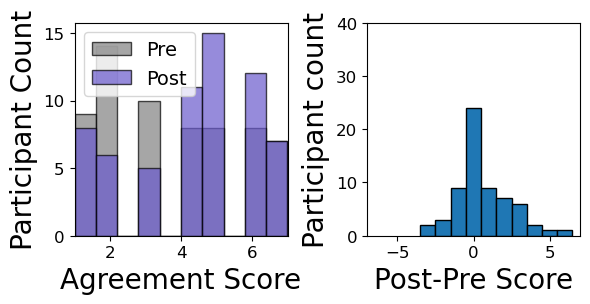

In [5]:
from modules.plots import plot_score_diff_hist
from modules.tests import calculate_wilcoxon,summarize_score_comparison
pre_scores = data[f'{question_code}_pre']
post_scores = data[f'{question_code}_post']
plot_score_diff_hist(data,question_code,analysis)
W, p_value, Z, effect_size = calculate_wilcoxon(pre_scores,post_scores)
summarize_score_comparison(analysis, question_code, data, W, p_value, Z, effect_size,display=True)
save_variables(data_reports_path,f'{analysis}-Wilcoxon-N',len(post_scores))

In [6]:
save_descriptive_stats(data_reports_path,f'{analysis}-{quantitative_default}',data[quantitative_default])

# Flag the outliers of the objective metric using the Interquartile Range (IQR) method
from modules.utils import get_outlier_bounds
lower_bound,upper_bound = get_outlier_bounds(data[{quantitative_default}])
data[f'{quantitative_default}-outlier'] = ((data[{quantitative_default}] < lower_bound) | (data[{quantitative_default}] > upper_bound)).astype(int)

### Calculate the correlations between subjective scores and the quantitative metric - Table 2

In [9]:
from modules.tests import summarize_spearman_results,compare_correlations_zou, compare_correlations_steiger
from scipy.stats import spearmanr
from modules.plots import plot_corr_raw

# Data without the outliers
correlation_data = data[data[f'{quantitative_default}-outlier'] == 0]
sample_size = len(correlation_data)

# Mark the outliers for visualization
outlier_data = data[data[f'{quantitative_default}-outlier'] == 1]
save_variables(data_reports_path,f'{analysis}-non-outlier-N',len(correlation_data))
save_variables(data_reports_path,f'{analysis}-outlier-N',len(outlier_data))

# Quick check that counts add up to total
total_check = len(outlier_data) + len(correlation_data)
if total_check != len(data):
    raise ValueError(
        f"Outlier/non-outlier counts ({total_check}) do not add up to total data length ({len(data)}). "
        f"Possible missing or invalid values in '{quantitative_default}-outlier'.")

# Calculate the spearman correlations
results = {"pre_spearman": spearmanr(correlation_data[f'{question_code}_pre'], correlation_data[quantitative_default]),
        "post_spearman": spearmanr(correlation_data[f'{question_code}_post'], correlation_data[quantitative_default]),
        "diff_spearman": spearmanr(correlation_data[f'{question_code}_diff'], correlation_data[quantitative_default]),
        "pre_post_r": spearmanr(correlation_data[f'{question_code}_pre'].tolist(), correlation_data[f'{question_code}_post'].tolist())}

# This part of the code compares the correlation(pre-score,objective metric) with correlation(post-score, objecive metric) using two approaches

# Zou confidence interval approach
lower_zou, upper_zou = compare_correlations_zou(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size)

# Steiger's test using two-tailed and one-tailed comparisons
t_steiger2,p_steiger2 = compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=True)
t_steiger1,p_steiger1= compare_correlations_steiger(results["pre_spearman"][0], results["post_spearman"][0], results["pre_post_r"][0], sample_size,twotailed=False)

# Summarize the results
summarize_spearman_results(analysis, quantitative_default, results, lower_zou, upper_zou,t_steiger2,p_steiger2,t_steiger1,p_steiger1)

+----+------------------------------------------+---------+
|    | Metric                                   |   Value |
+====+==========================================+=========+
|  0 | times-pre-median_daily_hours-spearman-r  |   0.1   |
+----+------------------------------------------+---------+
|  1 | times-pre-median_daily_hours-spearman-p  |   0.42  |
+----+------------------------------------------+---------+
|  2 | times-post-median_daily_hours-spearman-r |   0.18  |
+----+------------------------------------------+---------+
|  3 | times-post-median_daily_hours-spearman-p |   0.154 |
+----+------------------------------------------+---------+
|  4 | times-diff-median_daily_hours-spearman-r |   0.1   |
+----+------------------------------------------+---------+
|  5 | times-diff-median_daily_hours-spearman-p |   0.437 |
+----+------------------------------------------+---------+
|  6 | times-median_daily_hours-zou-upper       |   0.15  |
+----+----------------------------------

### Figure A8: Check if there are any subsample effects or recency effects. 

The recency effect is checked by correlating the quantitative metric calculated based on the last donation month with the subjective scores. If the pre-post change was statistically significant, an asterisk is added on top of the result. Otherwise, the larger size of the dots indicates the significance for the pre- and post- correlations. 

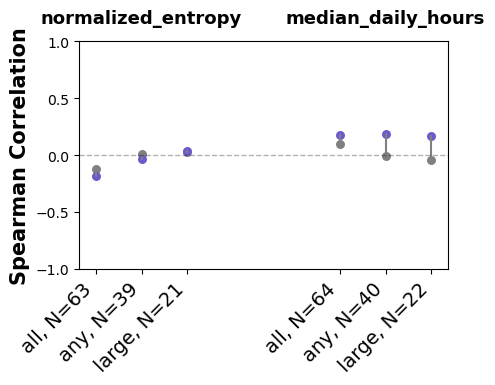

In [10]:
# Define subsets based on response differences
from modules.plots import plot_corr_differences
plot_corr_differences(data,question_code,quantitative_columns,analysis)

###  Plot the correlations between the objective metric and the subjective scores for given subsamples

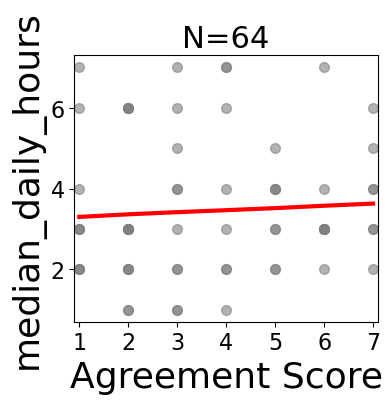

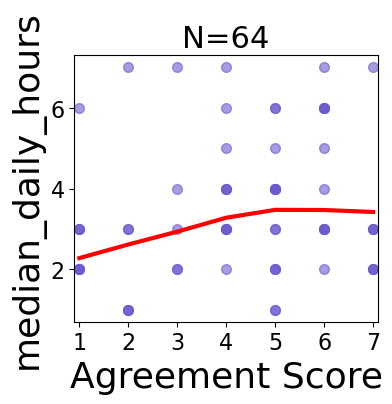

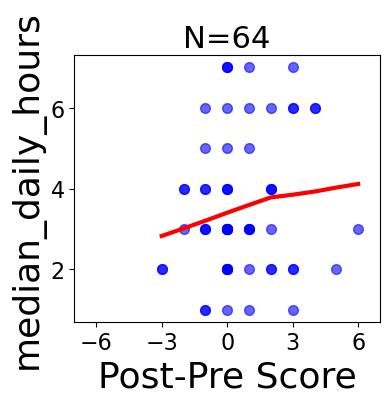

In [12]:
subsample = 'all'
sample_data = data

correlation_data = sample_data[sample_data[f'{quantitative_default}-outlier'] == 0]
outlier_data = sample_data[sample_data[f'{quantitative_default}-outlier'] == 1]

from modules.plots import plot_corr_raw
plot_corr_raw(correlation_data,outlier_data,question_code,'pre',analysis,quantitative_default,color=pre_color,label=subsample)
plot_corr_raw(correlation_data,outlier_data,question_code,'post',analysis,quantitative_default,color=post_color,label=subsample)
plot_corr_raw(correlation_data,outlier_data,question_code,'diff',analysis,quantitative_default,color=default_color,label=subsample)